In [77]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [78]:
# === 1. ODB GLODAP API fetch ===
cruise = "21OR19910626" # OR1_287 in 1991
glodap_url = "https://ecodata.odb.ntu.edu.tw/glodap/v2/2023/"
glodap_params = {
    "cruise": cruise,
    "append": "temperature,salinity,oxygen"
}
resp_glodap = requests.get(glodap_url, params=glodap_params)
resp_glodap.raise_for_status()
glodap_df = pd.DataFrame(resp_glodap.json())

In [79]:
print(glodap_df.head())

       expocode station  region  cast_number  year  month  latitude  \
0  21OR19910626     9.0       8            1  1991      6     21.75   
1  21OR19910626     9.0       8            1  1991      6     21.75   
2  21OR19910626     9.0       8            1  1991      6     21.75   
3  21OR19910626     9.0       8            1  1991      6     21.75   
4  21OR19910626     9.0       8            1  1991      6     21.75   

   longitude  bottomdepth  maxsampdepth  bottle  pressure  depth  \
0      122.0       4000.0         995.0    10.0     350.0  348.0   
1      122.0       4000.0         995.0     9.0     550.0  546.0   
2      122.0       4000.0         995.0     8.0     699.0  693.0   
3      122.0       4000.0         995.0     7.0     850.0  843.0   
4      122.0       4000.0         995.0     6.0     995.0  986.0   

               datetime                                                doi  \
0  1991-06-27T02:54:00Z  https://doi.org/10.3334/cdiac/otg.pacifica_21o...   
1  1991-

In [103]:
# === 2. Compute bounding box with 0.25 degree buffer ===
buffer = 0.25
Test = False
lon0 = glodap_df["longitude"].min() - buffer
lon1 = 130.0 if Test else glodap_df["longitude"].max() + buffer
lat0 = glodap_df["latitude"].min() - buffer
lat1 = glodap_df["latitude"].max() + buffer
print(f"Bounding box: ({lon0}, {lat0}), ({lon1}, {lat1})") 

Bounding box: (120.64, 21.498), (129.25, 22.162)


In [81]:
# === 3. ODB WOA23 API fetch ===
woa_url = "https://eco.odb.ntu.edu.tw/api/woa23"
# Finer grid for temperature/salinity
woa_params_ts = {
    "lon0": lon0, "lon1": lon1,
    "lat0": lat0, "lat1": lat1,
    "dep0": 0, "dep1": 10000,
    "parameter": "temperature,salinity",
    "grid": 0.25,
    "time_period": 0,
    "append": "an"
}
# Coarser grid for oxygen
woa_params_o2 = {
    "lon0": lon0, "lon1": lon1,
    "lat0": lat0, "lat1": lat1,
    "dep0": 0, "dep1": 10000,
    "parameter": "oxygen",
    "grid": 1,
    "time_period": 0,
    "append": "an"
}
resp_woa_ts = requests.get(woa_url, params=woa_params_ts)
resp_woa_ts.raise_for_status()
woa_ts_df = pd.DataFrame(resp_woa_ts.json())

resp_woa_o2 = requests.get(woa_url, params=woa_params_o2)
resp_woa_o2.raise_for_status()
woa_o2_df = pd.DataFrame(resp_woa_o2.json())


In [82]:
print(woa_ts_df.head())
woa_ts_df.shape[0]

       lon     lat  depth time_period  salinity_an  temperature_an
0  120.625  21.375    0.0           0    34.213490       27.226610
1  120.875  21.375    0.0           0    34.274113       27.254610
2  121.125  21.375    0.0           0    34.331600       27.261791
3  121.375  21.375    0.0           0    34.385700       27.249310
4  121.625  21.375    0.0           0    34.434212       27.222809


14688

In [83]:
print(woa_o2_df.head())
woa_o2_df.shape[0]

     lon   lat  depth time_period   oxygen_an
0  120.5  21.5    0.0           0  202.689224
1  121.5  21.5    0.0           0  202.203903
2  122.5  21.5    0.0           0  201.562378
3  123.5  21.5    0.0           0  202.162308
4  124.5  21.5    0.0           0  202.827942


2040

In [99]:
# Outer join to preserve all points from different resolution grids
woa_df = pd.merge(woa_ts_df, woa_o2_df, on=["lon", "lat", "depth", "time_period"], how="outer")


In [84]:
woa_df[woa_df.oxygen_an.notnull()].head()


,lon,lat,depth,time_period,salinity_an,temperature_an,oxygen_an
612,120.5,21.5,0.0,0,NaN,NaN,202.689224
613,120.5,21.5,5.0,0,NaN,NaN,201.918747
614,120.5,21.5,10.0,0,NaN,NaN,201.036728
615,120.5,21.5,15.0,0,NaN,NaN,200.326538
616,120.5,21.5,20.0,0,NaN,NaN,199.183456


In [85]:
# === 4. ODB CTD API fetch ===
ctd_url = "https://ecodata.odb.ntu.edu.tw/api/ctd"
ctd_params = {
    "lon0": lon0, "lon1": lon1,
    "lat0": lat0, "lat1": lat1,
    "dep0": 0, "dep1": 10000,
    "mode": 0,
    "append": "temperature,salinity,oxygen"
}
resp_ctd = requests.get(ctd_url, params=ctd_params)
resp_ctd.raise_for_status()
ctd_df = pd.DataFrame(resp_ctd.json())

In [86]:
print(ctd_df.head())
ctd_df.shape[0]

   longitude  latitude time_period  depth  temperature  salinity   oxygen
0     120.75      21.5           0      1       28.412    33.865  200.976
1     120.75      21.5           0    294       12.831    34.487  139.471
2     120.75      21.5           0     13       28.077    33.969  196.270
3     120.75      21.5           0    153       19.941    34.750  169.857
4     120.75      21.5           0      2       28.408    33.836  209.751


114687

In [ ]:
# Just used for checking the salinity data (at lon around 128 - 130)
# That's because we compare GLODAP for OR1-287 cruise, but CTD API can get only region average
# This region is more far away from Taiwan, and has less cruises, however, including OR1-294, 
# which has some outlier sanlinity data (much lower, 32.x), thus lowering the average salinity to 33.x
# If we can restrict to OR1-287 (from raw data in database), it should be consistent with GLODAP at 34.x
test_lon = 129 if Test else 128
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ctd_df[(ctd_df['depth']>=400) & (ctd_df['depth']<=1200) & (ctd_df['longitude']>=test_lon) & (ctd_df['longitude']<test_lon + 0.5)][['longitude','latitude','depth','temperature','salinity','oxygen']])

        longitude  latitude  depth  temperature  salinity  oxygen
112176      129.0     21.75    714        6.505    33.885     NaN
112180      129.0     21.75    715        6.482    33.884     NaN
112184      129.0     21.75    716        6.462    33.886     NaN
112188      129.0     21.75    717        6.444    33.886     NaN
112192      129.0     21.75    718        6.432    33.887     NaN
112196      129.0     21.75    719        6.423    33.888     NaN
112200      129.0     21.75    720        6.413    33.887     NaN
112204      129.0     21.75    721        6.478    33.849     NaN
112208      129.0     21.75    722        6.390    33.887     NaN
112212      129.0     21.75    723        6.371    33.885     NaN
112216      129.0     21.75    724        6.342    33.888     NaN
112220      129.0     21.75    725        6.406    33.850     NaN
112224      129.0     21.75    726        6.313    33.889     NaN
112228      129.0     21.75    727        6.295    33.889     NaN
112232    

In [88]:
# compared the corresponding data in GLODAP dataset
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(glodap_df[(glodap_df['depth']>=0) & (glodap_df['depth']<=1500) & (glodap_df['longitude']>=128) & (glodap_df['longitude']<=128.5)][['longitude','latitude','depth','temperature','salinity','oxygen']])

     longitude  latitude   depth  temperature  salinity   oxygen
153      128.0     21.75     0.0       29.817    34.730  201.780
154      128.0     21.75    50.0       25.487    34.758  218.410
155      128.0     21.75   149.0       21.063    34.930  207.290
156      128.0     21.75   346.0       16.074    34.717  202.730
157      128.0     21.75   542.0       10.253    34.285  159.790
158      128.0     21.75   695.0        6.180    34.160  108.970
159      128.0     21.75   890.0        4.288    34.311   61.370
160      128.0     21.75  1089.0        3.593    34.452   67.450
161      128.0     21.75  1287.0        3.033    34.508   78.945
162      128.0     21.75  1486.0        2.660    34.566   98.800
165      128.5     21.75     0.0       30.101    34.736  205.010
166      128.5     21.75    50.0       26.723    34.713  222.110
167      128.5     21.75   149.0       21.134    34.929  207.290
168      128.5     21.75   349.0       16.130    34.721  205.960
169      128.5     21.75 

In [99]:
# === 5. Shared Plotting Functions ===
direction_fill = False
def plot_profile_average2(df, api_name, param_keys, param_names, units, lon_col, lat_col, max_depth=2000):
    fig, axs = plt.subplots(3, 1, figsize=(8, 14), constrained_layout=True)
    for i, param in enumerate(param_keys):
        df_subset = df[[lon_col, lat_col, 'depth', param]]
        df_clean = df_subset[df_subset['depth'] <= max_depth]
        df_grouped = df_clean.groupby([lon_col,'depth'])[param].mean().reset_index()

        # Use pivot to construct full longitude-depth matrix
        pivot_table = df_grouped.pivot(index='depth', columns=lon_col, values=param)
        pivot_table = pivot_table.sort_index().sort_index(axis=1)  # ensure depth and lon sorted
        # Direction fill for NaN values with limit=1: This only fills 1 missing column neighbor (e.g., if 128.5 & 129.5 exist, fill 129.0)
        if direction_fill:
            pivot_table_interp = pivot_table.copy()
            pivot_table_interp = pivot_table_interp.interpolate(axis=1, limit=1, limit_direction='both')
            X, Y = np.meshgrid(pivot_table_interp.columns.values, pivot_table_interp.index.values)
            Z = pivot_table_interp.values
        else:
            X, Y = np.meshgrid(pivot_table.columns.values, pivot_table.index.values)
            Z = pivot_table.values

        # Use pcolormesh which handles NaN values for sparse/gridded data better than contourf
        # pcm = axs[i].pcolormesh(X, Y, Z, cmap='coolwarm', shading='auto')
        # Instead, `countourf` only "looks around" the values in each grid cell ([i,j], [i+1,j], [i,j+1], [i+1,j+1]) and interpolates contour lines inside.
        # It does not fill NaN values, if meet NaN, it just drops the cell.
        levels = 128 if 'temperature' in param.lower() or 'oxygen' in param.lower() else 32
        cs = axs[i].contourf(X, Y, Z, cmap='coolwarm', levels=levels)
        cbar = fig.colorbar(cs, ax=axs[i]) # pcm
        cbar.set_label(f"{param_names[i]} ({units[i]})")
        axs[i].invert_yaxis()
        axs[i].set_ylabel('Depth (m)')
        axs[i].set_title(f"{param_names[i]} Profile")

    axs[-1].set_xlabel('Longitude (°E)')
    xticks = np.arange(int(X.min()), int(X.max()) + 1)
    for ax in axs:
        ax.set_xticks(xticks)

    fig.suptitle(f"Depth Profiles of ODB {api_name} API Data", fontsize=14)
    plt.show()
    
def plot_profile_average(df, api_name, param_keys, param_names, units, lon_col, lat_col, max_depth=2000):
    fig, axs = plt.subplots(3, 1, figsize=(8, 14), constrained_layout=True)
    for i, param in enumerate(param_keys):
        df_clean = df[[lon_col, lat_col, 'depth', param]].dropna()
        df_clean = df_clean[df_clean['depth']<=max_depth]
        df_grouped = df_clean.groupby([lon_col,'depth'])[param].mean().reset_index()
        lons = df_grouped[lon_col].values
        depths = df_grouped['depth'].values
        values = df_grouped[param].values
        unique_lons = np.unique(lons)
        unique_depths = np.unique(depths)
        x, y = np.meshgrid(unique_lons, unique_depths)
        mesh = np.full_like(x, np.nan, dtype=np.float32)
        for j in range(len(values)):
            lon_idx = np.where(unique_lons==lons[j])[0][0]
            depth_idx = np.where(unique_depths==depths[j])[0][0]
            mesh[depth_idx, lon_idx] = values[j]
        levels = 128 if 'temperature' in param or 'oxygen' in param else 32
        cs = axs[i].contourf(x, y, mesh, cmap='coolwarm', levels=levels)
        cbar = fig.colorbar(cs, ax=axs[i])
        cbar.set_label(f"{param_names[i]} ({units[i]})")
        axs[i].invert_yaxis()
        axs[i].set_ylabel('Depth (m)')
        axs[i].set_title(f"{param_names[i]} Profile")

    axs[-1].set_xlabel('Longitude (°E)')
    xticks = np.arange(int(lon0), int(lon1) + 1)
    for ax in axs:
        ax.set_xticks(xticks)
    
    fig.suptitle(f"Depth Profiles of ODB {api_name} API Data", fontsize=14)
    plt.show()

# === 6. Improved Scatter Plot for GLODAP ===
def plot_glodap_profiles(df, api_name, param_keys, param_names, units):
    fig, axs = plt.subplots(3, 1, figsize=(6, 12), constrained_layout=True)
    norm = Normalize(vmin=df['longitude'].min(), vmax=df['longitude'].max())
    cmap = plt.colormaps['viridis']

    for i, param in enumerate(param_keys):
        for station in df['station'].unique():
            sub = df[df['station'] == station].sort_values("depth")
            lon = sub["longitude"].mean()
            color = cmap(norm(lon))
            axs[i].plot(sub[param], sub["depth"], marker="o", linestyle="-", alpha=0.6, color=color)
        axs[i].invert_yaxis()
        axs[i].set_xlabel(f"{param_names[i]} ({units[i]})")
        axs[i].set_ylabel("Depth (m)")
        axs[i].set_title(f"{param_names[i]} Profile")
        axs[i].grid(True)
    fig.suptitle(f"OR1-287 Bottle Profiles of ODB {api_name} API Data", fontsize=14)
    plt.show()



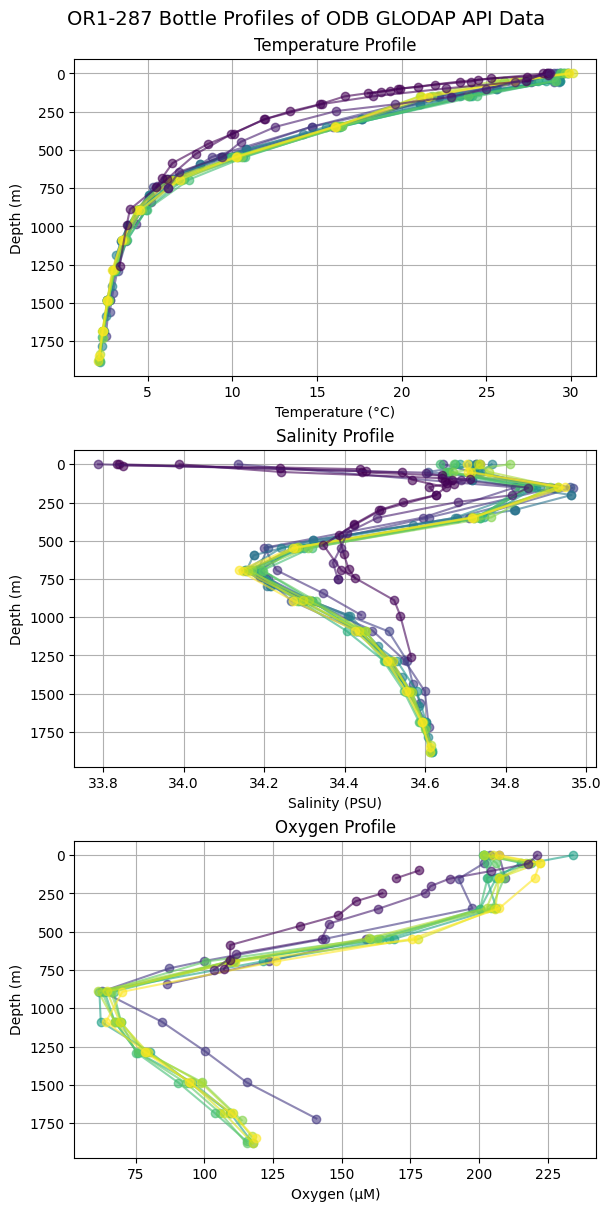

In [90]:
# === 6. Plot each API ===
plot_glodap_profiles(glodap_df, "GLODAP", ["temperature", "salinity", "oxygen"], ["Temperature", "Salinity", "Oxygen"], ["°C", "PSU", "μM"])



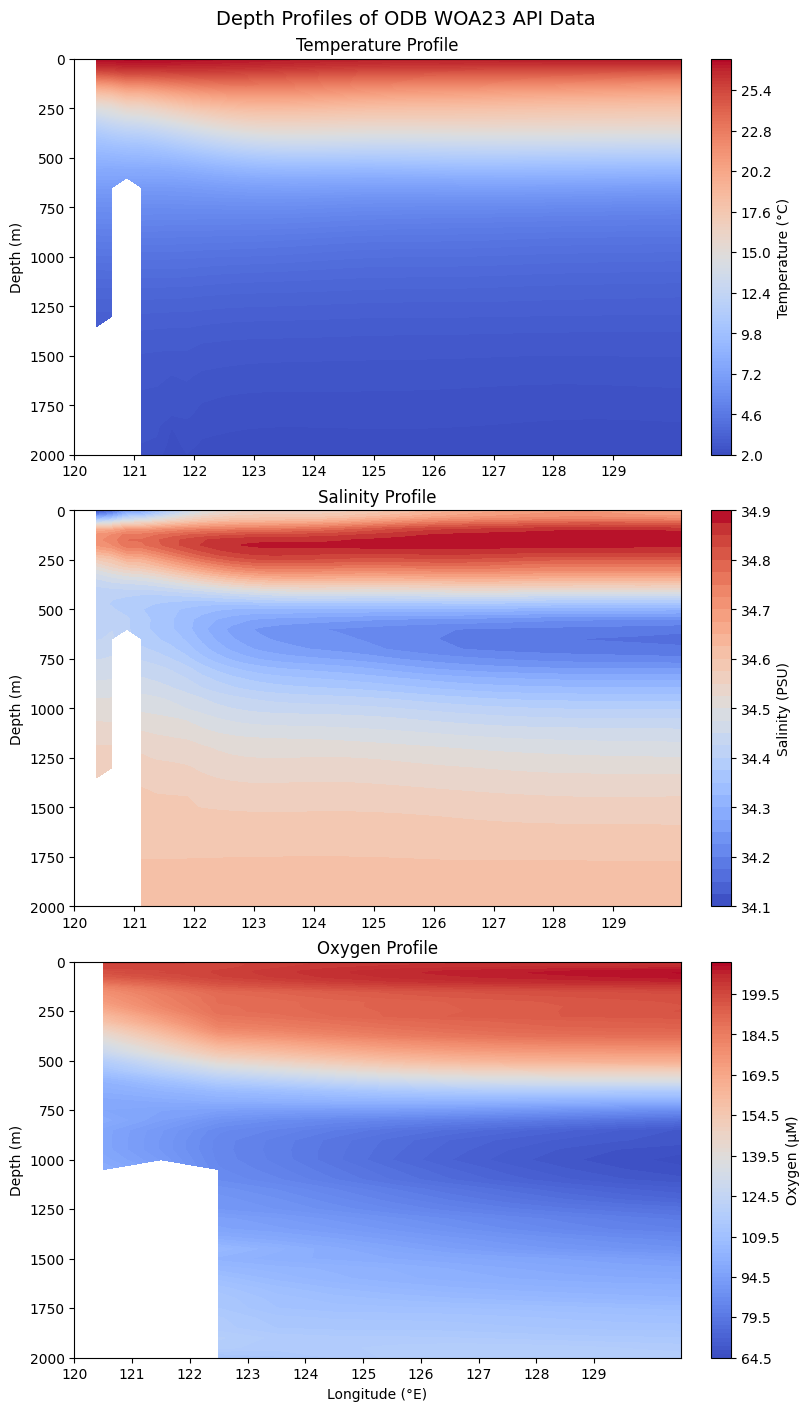

In [91]:
plot_profile_average(woa_df, "WOA23", ["temperature_an", "salinity_an", "oxygen_an"], ["Temperature", "Salinity", "Oxygen"], ["°C", "PSU", "μM"], lon_col="lon", lat_col="lat", max_depth=2000)


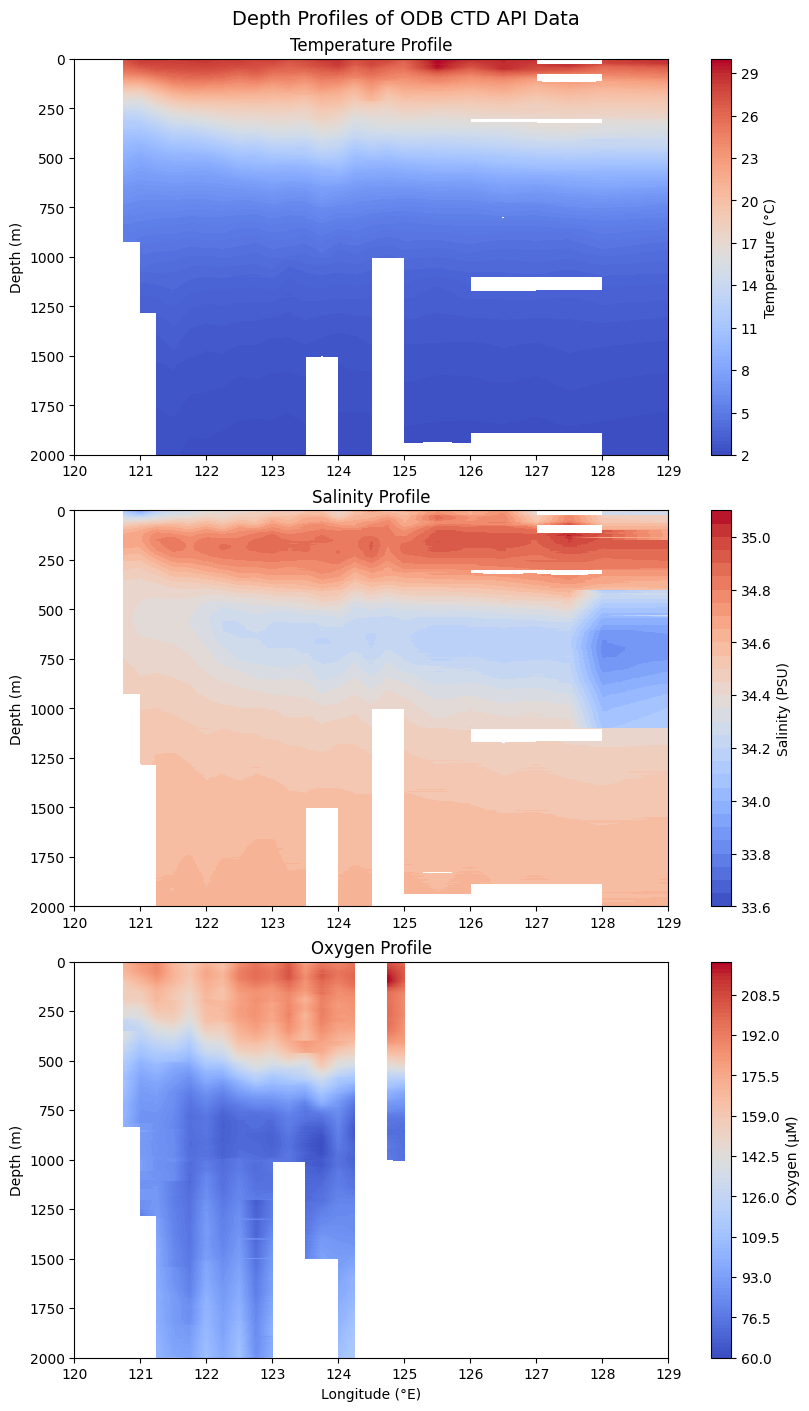

In [100]:
plot_profile_average2(ctd_df, "CTD", ["temperature", "salinity", "oxygen"], ["Temperature", "Salinity", "Oxygen"], ["°C", "PSU", "μM"], lon_col="longitude", lat_col="latitude", max_depth=2000)